# 02.1 - ML Experimentation with AutoML

The purpose of this notebook is to use [AutoML Tables](https://cloud.google.com/automl-tables) to train a classifier 
to predict whether a given trip will result in a tip > 20%. 

## Setup

In [1]:
import os
import pandas as pd
from datetime import datetime
import tensorflow_data_validation as tfdv
from tensorflow_transform.tf_metadata import schema_utils
from google.cloud.aiplatform import gapic as aip

In [2]:
PROJECT = 'ksalama-cloudml'
REGION = 'us-central1'

DATASET_DISPLAYNAME = 'chicago_taxi_tips'
AUTOML_MODEL_DISPLAYNAME = f'{DATASET_DISPLAYNAME}_classifier_automl'
API_ENDPOINT = f"{REGION}-aiplatform.googleapis.com"
PARENT = f"projects/{PROJECT}/locations/{REGION}"

client_options = {"api_endpoint": API_ENDPOINT}

In [3]:
LOCAL_WORKSPACE = '_workspace'
LOCAL_DATA_DIR = os.path.join(LOCAL_WORKSPACE, 'data')
RAW_SCHEMA_DIR = 'model_src/raw_schema/schema.pbtxt'

## Get Managed Dataset 

In [4]:
dataset_client = aip.DatasetServiceClient(client_options=client_options)
for dataset in dataset_client.list_datasets(parent=PARENT):
    if dataset.display_name == DATASET_DISPLAYNAME:
        dataset_uri = dataset.name
        break
        
dataset = dataset_client.get_dataset(name=dataset_uri)
print("Dataset uri:", dataset.name)
dataset_id = dataset.name.split('/')[-1]
print("Dataset id:", dataset_id)

Dataset uri: projects/900786220115/locations/us-central1/datasets/5309093049786171392
Dataset id: 5309093049786171392


## Load dataset schema

In [5]:
target_column = 'tip_bin'
data_split_column = 'data_split'
exclude_cloumns = ['trip_start_timestamp']

source_raw_schema = tfdv.load_schema_text(RAW_SCHEMA_DIR)
raw_feature_spec = schema_utils.schema_as_feature_spec(source_raw_schema).feature_spec
input_columns = [key for key in raw_feature_spec if key not in exclude_cloumns]
input_columns

['payment_type',
 'pickup_grid',
 'dropoff_grid',
 'loc_cross',
 'trip_month',
 'trip_day',
 'trip_day_of_week',
 'trip_hour',
 'trip_seconds',
 'trip_miles',
 'euclidean',
 'tip_bin']

## Train a classifier using AutoML Tables

In [6]:
automl_pipeline_client = aip.PipelineServiceClient(
    client_options=client_options)

In [ ]:
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


def train_automl_table(
    automl_pipeline_client,
    parent,
    dataset_id,
    model_display_name,
    input_columns,
    target_column
):
    transformations = [
        {"auto": {"column_name": column}} 
        for column in input_columns
    ]

    training_task_inputs_dict = {
        "targetColumn": target_column,
        "predictionType": "classification",
        "transformations": transformations,
        "trainBudgetMilliNodeHours": 1,
        "disableEarlyStopping": False,
        "optimizationObjective": "minimize-log-loss",
    }
    training_task_inputs = json_format.ParseDict(training_task_inputs_dict, Value())

    training_pipeline = {
        "display_name": f"train_{model_display_name}_{datetime.now().strftime('%Y%m%d%H%M%S')}",
        "training_task_definition": "gs://google-cloud-aiplatform/schema/trainingjob/definition/automl_tabular_1.0.0.yaml",
        "training_task_inputs": training_task_inputs,
        "input_data_config": {
            "dataset_id": dataset_id,
#             "fraction_split": {
#                 "training_fraction": 0.8,
#                 "validation_fraction": 0.1,
#                 "test_fraction": 0.1,
#             },
            "predefined_split": {
               "key": data_split_column 
            }
            
        },
        "model_to_upload": {"display_name": model_display_name},
    }

    response = automl_pipeline_client.create_training_pipeline(
        parent=parent, training_pipeline=training_pipeline
    )
    
    print("response:", response)

In [ ]:
train_automl_table(
    automl_pipeline_client=automl_pipeline_client,
    parent=PARENT,
    dataset_id=dataset_id,
    model_display_name=AUTOML_MODEL_DISPLAYNAME,
    input_columns=input_columns,
    target_column=target_column
)

In [ ]:
automl_pipeline_client.create_training_pipeline()

## List training jobs

In [ ]:
output = automl_pipeline_client.list_training_pipelines(parent=PARENT)
output

In [7]:
model_client = aip.ModelServiceClient(client_options=client_options)

In [8]:
model_list = model_client.list_models(parent=PARENT)

for entry in model_list:
    if entry.display_name == AUTOML_MODEL_DISPLAYNAME:
        model_uri = entry.name
        break

print(model_uri)

projects/900786220115/locations/us-central1/models/7313230068338130944


## Get Evaluation Metrics

In [9]:
evaluation_results = model_client.list_model_evaluations(parent=model_uri)
evaluation_results

ListModelEvaluationsPager<model_evaluations {
  name: "projects/900786220115/locations/us-central1/models/7313230068338130944/evaluations/1580641222752000421"
  metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml"
  metrics {
    struct_value {
      fields {
        key: "auPrc"
        value {
          number_value: 0.95514035
        }
      }
      fields {
        key: "auRoc"
        value {
          number_value: 0.9516639
        }
      }
      fields {
        key: "confidenceMetrics"
        value {
          list_value {
            values {
              struct_value {
                fields {
                  key: "f1Score"
                  value {
                    number_value: 0.6666667
                  }
                }
                fields {
                  key: "f1ScoreAt1"
                  value {
                    number_value: 0.8845723
                  }
                }
                fie

In [11]:
metrics = list(evaluation_results)[0].metrics

In [12]:
list(metrics.keys())

['logLoss', 'confidenceMetrics', 'confusionMatrix', 'auRoc', 'auPrc']

In [13]:
print("Log loss:", metrics['logLoss'])
print("AUC - PRC:", metrics['auPrc'])
print("AUC - ROC:", metrics['auRoc'])

Log loss: 0.26286143
AUC - PRC: 0.95514035
AUC - ROC: 0.9516639


In [14]:
entries = metrics['confusionMatrix']['rows']

print("TN:", entries[0][0])
print("FP:", entries[0][1])
print("FN:", entries[1][0])
print("TP:", entries[1][1])

total = sum(entries[0]) + sum(entries[1])
accuracy = (entries[0][0] + entries[1][1]) / total

print(f"Accuracy: {round(accuracy * 100, 2)}%")

TN: 411104.0
FP: 89799.0
FN: 2545.0
TP: 296568.0
Accuracy: 88.46%


In [15]:
confidence_metrics = list(evaluation_results)[0].metrics['confidenceMetrics']
list(confidence_metrics[-1].keys())

['f1ScoreAt1',
 'falseNegativeCount',
 'confidenceThreshold',
 'trueNegativeCount',
 'precision',
 'precisionAt1',
 'f1Score']

In [16]:
thresholds = []
scores = []

for m in confidence_metrics:
    entry = dict(m)
    f1Score = entry['f1Score']
    threshold = 0
    
    if 'confidenceThreshold' in entry:
        threshold = entry['confidenceThreshold']
        
    thresholds.append(threshold)
    scores.append(f1Score)

<AxesSubplot:xlabel='threshold'>

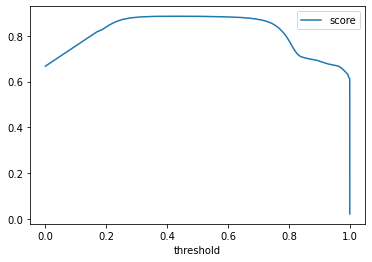

In [17]:
pd.DataFrame(
    {
        'threshold': thresholds,
        'score': scores
    }
).plot(kind='line', x='threshold', y='score')